The notebook uses the following references:
- https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb
- Machine Learning Mastery's implementation of Cycle GANs (from the book [Generative Adversarial Networks with Python](https://machinelearningmastery.com/generative_adversarial_networks/)).

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!wget https://gist.githubusercontent.com/sayakpaul/1e0f3ae671b62413d9ee98626a71f23d/raw/31df245ab4476db32563f6b86e3a22890df6e487/download_cyclegan_data.sh

--2020-03-26 10:48:56--  https://gist.githubusercontent.com/sayakpaul/1e0f3ae671b62413d9ee98626a71f23d/raw/31df245ab4476db32563f6b86e3a22890df6e487/download_cyclegan_data.sh
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800 [text/plain]
Saving to: ‘download_cyclegan_data.sh’

download_cyclegan_d 100%[===================>]     800  --.-KB/s    in 0s      

2020-03-26 10:48:57 (201 MB/s) - ‘download_cyclegan_data.sh’ saved [800/800]



In [3]:
!sh download_cyclegan_data.sh monet2photo

download_cyclegan_data.sh: 5: download_cyclegan_data.sh: [[: not found
for details.

--2020-03-26 10:49:05--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305231073 (291M) [application/zip]
Saving to: ‘/content/monet2photo.zip’

/content/monet2phot 100%[===================>] 291.09M  21.1MB/s    in 15s     

2020-03-26 10:49:21 (19.7 MB/s) - ‘/content/monet2photo.zip’ saved [305231073/305231073]



In [4]:
!ls monet2photo/

testA  testB  trainA  trainB


In [5]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (35.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
!tree --dirsfirst --filelimit 10 monet2photo

monet2photo
├── testA [121 entries exceeds filelimit, not opening dir]
├── testB [751 entries exceeds filelimit, not opening dir]
├── trainA [1072 entries exceeds filelimit, not opening dir]
└── trainB [6287 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [0]:
# imports
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from os import listdir
import numpy as np
from tqdm import tqdm

In [0]:
# load all images in a directory into memory
def load_images(path, size=(128,128)):
    data_list = list()
    
    # enumerate filenames in directory, assume all are images
    for filename in tqdm(listdir(path)):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    
    return np.array(data_list)

In [9]:
# dataset path
path = "monet2photo/"

# load dataset A
dataA1 = load_images(path + "trainA/") 
dataA2 = load_images(path + "testA/") 
dataA = np.concatenate([dataA1, dataA2])
print("Loaded dataA: ", dataA.shape)

# load dataset B
dataB1 = load_images(path + "trainB/") 
dataB2 = load_images(path + "testB/") 
dataB = np.concatenate([dataB1, dataB2])
print("Loaded dataB: ", dataB.shape)

  1%|          | 68/6287 [00:00<00:09, 676.38it/s]

Loaded dataA:  (1193, 128, 128, 3)


100%|██████████| 751/751 [00:01<00:00, 685.19it/s]


Loaded dataB:  (7038, 128, 128, 3)


In [0]:
import matplotlib.pyplot as plt

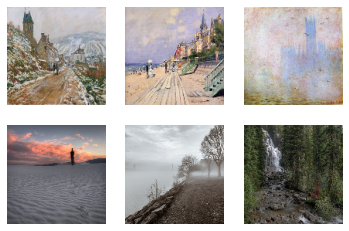

In [11]:
n_samples = 3

# plot source images
for i in range(n_samples): 
    plt.subplot(2, n_samples, 1 + i) 
    plt.axis("off") 
    plt.imshow(dataA[i].astype("int"))
 
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i) 
    plt.axis("off") 
    plt.imshow(dataB[i].astype("int"))   

In [0]:
# needed for instance normalization
!pip install -q  --no-deps tensorflow-addons~=0.7

In [0]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa

In [0]:
# define the discriminator model
def define_discriminator(image_shape):
    # source image input
    in_image = Input(shape=image_shape)

    # init
    init = RandomNormal(stddev=0.02)
    
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # patch output
    patch_out = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d) 
    
    # define model
    model = Model(in_image, patch_out)
    
    return model 

In [0]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(input_layer) 
    g = tfa.layers.InstanceNormalization(axis=3)(g)
    g = Activation("relu")(g)
    
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(g) 
    g = tfa.layers.InstanceNormalization(axis=3)(g)
    
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    
    return g

In [0]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=6):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)

	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)

	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	out_image = Activation('tanh')(g)

	# define model
	model = Model(in_image, out_image)

	return model

In [17]:
# discriminator
discriminator = define_discriminator((128,128,3))
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 32, 32, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       524544

In [18]:
# generator
generator = define_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

In [0]:
# # output omitted for brevity
# from tensorflow.keras.utils import plot_model
# plot_model(discriminator, "discriminator.png", show_shapes=True)
# plot_model(generator, "generator.png", show_shapes=True)

In [0]:
# input shape
image_shape = (128, 128, 3)

# generator: A -> B
g_model_AtoB = define_generator(image_shape, n_resnet=6)
# generator: B -> A
g_model_BtoA = define_generator(image_shape, n_resnet=6)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

In [0]:
import tensorflow as tf

In [0]:
def real_mse_loss(D_out):
    mse = tf.keras.losses.MeanSquaredError()
    # how close is the produced output from being "real"?
    # label for real is 1
    ones = tf.ones_like(len(D_out), dtype=tf.float32)
    return mse(D_out, ones)

def fake_mse_loss(D_out):
    mse = tf.keras.losses.MeanSquaredError()
    # how close is the produced output from being "fake"?
    # label for fake is 0
    zeros = tf.zeros_like(len(D_out), dtype=tf.float32)
    return mse(D_out, zeros)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    mae = tf.keras.losses.MeanAbsoluteError()
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = mae(real_im, reconstructed_im)
    # return weighted loss
    return lambda_weight*reconstr_loss 

In [0]:
# these values come from the original paper
###########################################

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

# create optimizers for the generators and discriminators
g_AtoB_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
g_BtoA_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
d_model_A_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
d_model_B_opt = Adam(lr, beta_1=beta1, beta_2=beta2)

In [0]:
@tf.function
def train_discriminator_A(dA, gBA, images_B, images_A, d_model_A_opt):
    with tf.GradientTape() as tape:
        # discriminator A
        dA_real_logits = dA(images_A)
        dA_real_loss = real_mse_loss(dA_real_logits)

        # discriminator A on fake stuff
        fake_A = gBA(images_B)
        dA_fake_logits = dA(fake_A)
        dA_fake_loss = fake_mse_loss(dA_fake_logits)

        # total dA loss
        total_dA_loss = dA_real_loss + dA_fake_loss

    # compute gradients and backprop
    dA_grads = tape.gradient(total_dA_loss, dA.trainable_variables)
    d_model_A_opt.apply_gradients(zip(dA_grads, dA.trainable_variables))

    return total_dA_loss

# <-------------------------------------------------------------------->

@tf.function
def train_discriminator_B(dB, gAB, images_A, images_B, d_model_B_opt):
    with tf.GradientTape() as tape:
        # discriminator B
        dB_real_logits = dB(images_B)
        dB_real_loss = real_mse_loss(dB_real_logits)

        # discriminator B on fake stuff
        fake_B = gAB(images_A)
        dB_fake_logits = dB(fake_B)
        dB_fake_loss = fake_mse_loss(dB_fake_logits)

        # total dA loss
        total_dB_loss = dB_real_loss + dB_fake_loss

    # compute gradients and backprop
    dB_grads = tape.gradient(total_dB_loss, dB.trainable_variables)
    d_model_B_opt.apply_gradients(zip(dB_grads, dB.trainable_variables))

    return total_dB_loss

In [0]:
@tf.function
def train_generator_AB(dB, gAB, gBA, images_A, images_B, g_AtoB_opt):
    ###### Generator AB ######
    #########################
    with tf.GradientTape() as tape:
        # generate images from domain A to domain B, compute loss (weight 1) via
        # discriminator B
        fake_B = gAB(images_A)
        dB_fake_logits = dB(fake_B)
        gAB_loss = real_mse_loss(dB_fake_logits)

        # # identity loss (weight 5)
        # identity_B = gAB(images_B)
        # id_loss = cycle_consistency_loss(images_B, identity_B, 5)

        # cycle consistency loss (weight 10)
        reconstructed_A = gBA(fake_B)
        reconstructed_A_loss = cycle_consistency_loss(images_A, reconstructed_A, 10)

        # total loss
        total_gAB_loss = gAB_loss + reconstructed_A_loss
    
    # compute gradients and backprop
    gAB_grads = tape.gradient(total_gAB_loss, gAB.trainable_variables)
    g_AtoB_opt.apply_gradients(zip(gAB_grads, gAB.trainable_variables))

    return total_gAB_loss
    
# <-------------------------------------------------------------------->

@tf.function
def train_generator_BA(dA, gBA, gAB, images_B, images_A, g_BtoA_opt):
    ###### Generator BA ######
    #########################
    with tf.GradientTape() as tape:
        # generate images from domain B to domain A, compute loss (weight 1) via
        # discriminator A
        fake_A = gBA(images_B)
        dA_fake_logits = dA(fake_A)
        gBA_loss = real_mse_loss(dA_fake_logits)

        # # identity loss (weight 5)
        # identity_A = gBA(images_A)
        # id_loss = cycle_consistency_loss(images_A, identity_A, 5)

        # cycle consistency loss (weight 10)
        reconstructed_B = gAB(fake_A)
        reconstructed_B_loss = cycle_consistency_loss(images_B, reconstructed_B, 10)

        # total loss
        total_gBA_loss = gBA_loss + reconstructed_B_loss
    
    # compute gradients and backprop
    gBA_grads = tape.gradient(total_gBA_loss, gBA.trainable_variables)
    g_BtoA_opt.apply_gradients(zip(gBA_grads, gBA.trainable_variables))

    return total_gBA_loss

In [0]:
# check if everything works (should be run only once)

sample_Images_A = dataA[32].reshape(1, 128, 128, 3)
sample_Images_B = dataB[32].reshape(1, 128, 128, 3)

print(train_discriminator_A(d_model_A, g_model_BtoA, sample_Images_B, sample_Images_A, d_model_A_opt))
print(train_discriminator_B(d_model_B, g_model_AtoB, sample_Images_A, sample_Images_B, d_model_B_opt))

print(train_generator_AB(d_model_B, g_model_AtoB, g_model_BtoA, sample_Images_A, sample_Images_B, g_AtoB_opt))
print(train_generator_BA(d_model_A, g_model_BtoA, g_model_AtoB, sample_Images_B, sample_Images_A, g_BtoA_opt))

In [0]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		plt.subplot(1, len(images), 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i])
		# title
		plt.title(titles[i])
	plt.show()
 
def show_model_progress(gAB, gBA, dataA, dataB):
	# A -> B -> A
	print("[INFO] Domain A to Domain B")
	real_A = select_sample(dataA, 1)
	B_generated  = gAB.predict(real_A)
	A_reconstructed = gBA.predict(B_generated)
	show_plot(real_A, B_generated, A_reconstructed)

	# B -> A -> B
	print("[INFO] Domain B to Domain A")
	real_B = select_sample(dataB, 1)
	A_generated  = gBA.predict(real_B)
	B_reconstructed = gAB.predict(A_generated)
	show_plot(real_B, A_generated, B_reconstructed)

In [0]:
# scale data to ([-1, 1]) and convert to TF Dataset
scaled_dataA = (dataA - 127.5) / 127.5
scaled_dataB = (dataB - 127.5) / 127.5
data_A_TF = tf.data.Dataset.from_tensor_slices(scaled_dataA).batch(16).prefetch(100)
data_B_TF = tf.data.Dataset.from_tensor_slices(scaled_dataB).batch(16).prefetch(100)

In [0]:
# metrics to keep track of the mean loss for each epoch
gen_AB_metric = tf.keras.metrics.Mean()
gen_BA_metric = tf.keras.metrics.Mean()
disc_A_metric = tf.keras.metrics.Mean()
disc_B_metric = tf.keras.metrics.Mean()

In [28]:
!nvidia-smi

Thu Mar 26 10:51:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |    871MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# constants
visualize_every = 50
epochs = 100
steps_per_epoch = min(len(dataA)//16, len(dataB)//16)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0 step: 0 dA_loss: 3.001 dB_loss: 6.970 gAB_loss :8.975 gBA_loss: 7.458
[INFO] Domain A to Domain B


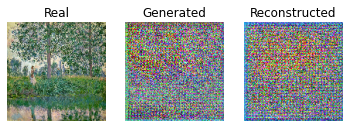

[INFO] Domain B to Domain A


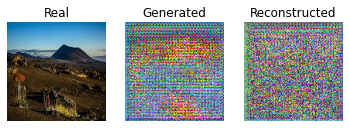

epoch: 0 step: 1 dA_loss: 5.036 dB_loss: 7.945 gAB_loss :7.892 gBA_loss: 8.581
epoch: 0 step: 2 dA_loss: 11.546 dB_loss: 3.180 gAB_loss :7.443 gBA_loss: 10.956
epoch: 0 step: 3 dA_loss: 3.206 dB_loss: 3.258 gAB_loss :7.190 gBA_loss: 7.930
epoch: 0 step: 4 dA_loss: 3.856 dB_loss: 3.180 gAB_loss :6.954 gBA_loss: 7.611
epoch: 0 step: 5 dA_loss: 2.330 dB_loss: 2.206 gAB_loss :6.935 gBA_loss: 8.665
epoch: 0 step: 6 dA_loss: 2.020 dB_loss: 1.919 gAB_loss :6.770 gBA_loss: 7.522
epoch: 0 step: 7 dA_loss: 1.758 dB_loss: 1.793 gAB_loss :6.872 gBA_loss: 7.663
epoch: 0 step: 8 dA_loss: 1.812 dB_loss: 1.679 gAB_loss :6.680 gBA_loss: 7.932
epoch: 0 step: 9 dA_loss: 2.166 dB_loss: 1.613 gAB_loss :6.748 gBA_loss: 7.804
epoch: 0 step: 10 dA_loss: 2.114 dB_loss: 1.505 gAB_loss :6.644 gBA_loss: 8.171
epoch: 0 step: 11 dA_loss: 2.103 dB_loss: 1.495 gAB_loss :6.762 gBA_loss: 8.216
epoch: 0 step: 12 dA_loss: 1.990 dB_loss: 1.431 gAB_loss :6.546 gBA_loss: 9.249
epoch: 0 step: 13 dA_loss: 2.264 dB_loss: 1.295

In [0]:
# training loop
for epoch in tqdm(range(epochs)):
    # reset the iterators after each epoch
    iter_A = iter(data_A_TF)
    iter_B = iter(data_B_TF)
    # iterate through the steps per epoch
    for step in range(steps_per_epoch):
        # get the images
        images_A = iter_A.next()
        images_B = iter_B.next()

        # train the discriminator A
        dA_loss = train_discriminator_A(d_model_A, g_model_BtoA, images_B, images_A, d_model_A_opt)
        disc_A_metric(dA_loss)

        # train the discriminator B
        dB_loss = train_discriminator_B(d_model_B, g_model_AtoB, images_A, images_B, d_model_B_opt)
        disc_B_metric(dB_loss)

        # train generator AB
        gen_AB_loss = train_generator_AB(d_model_B, g_model_AtoB, g_model_BtoA, images_A, images_B, g_AtoB_opt)
        gen_AB_metric(gen_AB_loss)

        # train generator BA
        gen_BA_loss = train_generator_BA(d_model_A, g_model_BtoA, g_model_AtoB, images_B, images_A, g_BtoA_opt)
        gen_BA_metric(gen_BA_loss)

        # logging
        print(f"epoch: {epoch} step: {step} dA_loss: {disc_A_metric.result():.3f} dB_loss: {disc_B_metric.result():.3f} "
            f"gAB_loss :{gen_AB_metric.result():.3f} gBA_loss: {gen_BA_metric.result():.3f}")

        # visualization
        if step % visualize_every == 0:
            show_model_progress(g_model_AtoB, g_model_BtoA, scaled_dataA, scaled_dataB)

        # reset metrics
        disc_A_metric.reset_states()
        disc_B_metric.reset_states()
        gen_AB_metric.reset_states()
        gen_BA_metric.reset_states()